# Predicting PC Game Review Sentiments from its Content and Playtime
## Introduction
### Objective
This project aims to build a modelt that can reliably and accurately identify whether a reviewer reccomends the game they're reviewing, given the data that's available at the time of review. 

As part of this objective, we aim to also investigate the efficicy of different models, the methods and best practices of preparing the data and training them, and the relative value of the different variables that can be used to classify the reviews. 
### Background
Steam, a major online PC game marketplace, allows its users to leave reviews for the games they buy and play. These reviews then act as a way for propsective buyers to make purchasing decisions and for game developers to understand the general reception of their games and their strengths & weaknesses. 

Reviews on Steam don't only contain what the reviewer wrote about the game, but also if they reccomended it or not as well as other variables about the user such as how long they played the game when they left the review, how long they've played it in total, and more. Users can also open the profile of a reviewr to see how many games they own and how many reviews they wrote. For a buyer or developer, this is information that helps undestand the reviewer and their sentiment, but if we were to build a model that tries to predict that sentiment, what techniques and data would be most fruitful.
### Motivation and Use Cases
As an avid gamer, checking reviews before spending money and time on a game is something I, and others, do to make sure we're making informed decisions. The value of understanding the general community sentiment behind games is really important, and on several platforms, users can leave scores or binary positive/negative sentiments to summarize their opinions. 

But both consumers and curious game developers face obstacles when trying to understand how communities feel. First, there are many cases of improperly scored/reccomended reviews where the implied sentiment from the review's content doesn't match the reccomendation the writer gives. The simplest example would be someone who wrote "I love this game" , but gives it 2/5 stars or a thumbs down. These misclassficiations can come from user error or failed attempts by game developers to manipulate the system by purchasing services that post positive reviews on their games. I'm sure some of us have seen these confilicting sentiment/scores even on Amazon or other marketplaces, but they tend to be uncommon. While there's still value for platforms to properly clasfiy their reviews, there's another use case that can really benefit from sentiment classification.

That use case is understanding the sentiment of users in community forums where they generally discuss and review games without leaving official, easily identifiable scores. On forums and social platforms like Reddit, a propsective buyer or developer would have to read tens or hundreds of posts and comments to get a better idea of how the community feels about a game since there are no scores or identifiers that can be quickly aggregated like on marketplaces. Thus, being able to mass scrape and classify these comments can make it much easier to navigate, aggregate and analyze the sentiments of online communities.

## Method

### Data
To build this classifier, I first acquired large data set of [21 million Steam reviews](https://www.kaggle.com/najzeko/steam-reviews-2021) that included sentiment, playtime and other measurements about the reviewers. I then performed some exploratory analysis on a subsample of that data to better understand the features it contains. I then took a randomized sample from the complete data set to be able to work at a more reasonable scale since I was building the project on my personal computer.

### Review Text
The next step would have normally been to analyze the different features in terms of the shape of their distributions, intercorrelations, and skews. In my case, wanting to get my feet wet early and knowing that the review text should be a strong predictor, I immediatly investigated, preprocessed, and iteratively built a working model that could reliably predict review sentiment. I used Tfidf vectorization for feature extraction and normalization, and a logistic regression classifier, both of which were implemented using Scikit Learn's libraries. I chose accuracy as the main performance indicator of the model because we're expecting the model to make the highest amount of correct predictions, and because it's an intuitive measurement.

### Other Variables
I then investigated the other available variables and ultimately went with the reviewer's playtime at the time of the review as a complimentary feature. The main reason other features were filtered out was that they were aggregates that were measured at the time the data was pulled, not when the review was written, so they don't give an appropriate picture of the athor's state at the time of the review.

### Model Optimization and Discussion
Finally, I built logstic regression and neural network based classification pipelines to test the effect of playtime as a feature in conjunction with the review text, and then optimized both models with a cross validated gridsearch over different parameters. The gridsearch results were analyzed and I then discussed the different strengths and potential applications of each model.

### Note
Early on, I decided to build this project over multiple notebooks to divide the different types of tasks that I worked on, and also for the project to have a sense of natural evolution. While this current notebook is the amalgamation of those stages, feel free to open the separate numbered files and see how each step went.

## Data Exploration and Preprocessing
### Available Data and Feature Selection


In [4]:
import pandas as pd
import numpy as np

# Check the measurements and data in the dataset
df = pd.read_csv(r'data\unprocessed\steam_reviews.csv', nrows=0)
print(df.columns)

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


Noting that our goal is to build a model that can classify an author's sentiment about a game, we can immediatly filter out a few columns that won't be relevant features. These include: 
- **Game related data:** app_name 
- **Identifiers:** review_id, author.steamid, app_id,
- **Responses to the review:** votes_helpful, votes_funny, weighted_vote_score, comment_count
- **Timestamps:** timestamp_created, timestamp_updated
- **Data measured after the review:** author.playtime_forever, author.playtime_last_two_weeks, author.last_played
- **Review attributes:** received_for_free, steam_purchase, written_during_early_access, language

The columns in the last category, aside from language, could potentially contribute to predicting the review's sentiment, but they were removed to keep the model more widely applicable.

The columns I chose as features were the review content (*'reviwe'*), *author.playtime_at_review*, *author.num_games_owned*, *author.num_reviews*. The target column is '**recommended**'. It represents the sentiment of the review that we're trying to predict. 

In [4]:
# Columns to keep
keep = ['review','recommended','author.playtime_at_review','author.num_games_owned','author.num_reviews']

#  Column filtering example
df_filtered = df[keep]
print(df_filtered.columns)

Index(['review', 'recommended', 'author.playtime_at_review',
       'author.num_games_owned', 'author.num_reviews'],
      dtype='object')



For the last two columns, *author.num_games* & *author.num_reviews*, I had thought that they were recorded at the time of the review, and started analyzing their data, but then I started feeling from that analysis that they could have been general account attributes. I then confirmed that they were indeed unrelated to the review time and removed them. But since I had already performed some rudimentary analysis on them, I'll still include it later in the project to show why I started doubting those columns.

## Review Text Classification
Staying true to how I progerssed through this project, I'll first cover how I prepared and built a model that could classify sentiment just from the contents of the reviews. Afterwards, I'll cover my investigation, processing and integration of other variables.

### Language Filtering
For this project, I chose to only classify English reviews. So, we need to see if other languages are present in the dataset and fitler them out. 

In [5]:
# Checking review languages
df = pd.read_csv(r'data\unprocessed\steam_reviews.csv', nrows=10000)
print(df.language.unique())

['schinese' 'english' 'turkish' 'spanish' 'russian' 'koreana' 'latam'
 'brazilian' 'portuguese' 'vietnamese' 'polish' 'french' 'german'
 'hungarian' 'ukrainian' 'tchinese' 'bulgarian' 'czech' 'italian' 'thai'
 'greek' 'dutch' 'finnish' 'romanian' 'japanese' 'swedish' 'danish'
 'norwegian']


In [6]:
# Filtering non-english reviews
df_english = df[df['language'].str.contains("english")].copy() # This can also been done with df.loc[...]
print(df_english.language.unique())

['english']


### Data Preprocessing

#### Text Processing

To properly tokenize a corpus of text documents into features, we have to preprocess those documents for our model to properly read and select words and features. For example, 'good', 'Good', and 'good.' are all the same word with the same sentiment but our word aggregating function would treat them all as separate features. To properly prepare our text data, we need to ensure that we have:
- All lowercase letters
- No symbols or numbers (some functions also don't like new lines)
- No nulls or empty documents (especially after removing symbols and numbers)

In [7]:
# A few examples of reviews in our data
df_english['review'].head(5)

3     One of the best RPG's of all time, worthy of a...
5                good story, good graphics. lots to do.
6                                              dis gud,
18    favorite game of all time cant wait for the Ne...
20                            Why wouldn't you get this
Name: review, dtype: object

In [21]:
df_processed = df_english.copy()

# Force all letters to lower case
df_processed['review'] = df_processed['review'].str.lower()

# Remove all non lower case letters (symbols, numbers, etc)
df_processed['review'] = df_processed['review'].str.replace('[^a-z\s]','', regex=True)

# Replace new lines with spaces
df_processed['review'] = df_processed['review'].str.replace('\n',' ')

# Only keep rows where reviews that have any lower case letter
df_processed = df_processed[df_processed['review'].str.contains('[a-z]', na=False)]

pd.concat([df_english['review'].rename('Before'), 
           df_processed['review'].rename('After')], axis=1).head(5)

,Before,After
3,"One of the best RPG's of all time, worthy of a...",one of the best rpgs of all time worthy of any...
5,"good story, good graphics. lots to do.",good story good graphics lots to do
6,"dis gud,",dis gud
18,favorite game of all time cant wait for the Ne...,favorite game of all time cant wait for the ne...
20,Why wouldn't you get this,why wouldnt you get this


#### Compiling and Sampling

Until now, we've been reading the first 'n' rows from an 8gb csv file because loading the whole file into memory would be quite difficult. Since we don't plan to train our model with all 21 million reviews, we'll take a smaller random sample from the data set. 

To do this, we'll load the file as chunks. We'll then drop the columns we don't need from those chunks greatly reducing their memory requirements, prerprocess the remaining columns, and contenate the chunks back into one dataframe that we can then export as a new processed CSV file that's much smaller in size.

In [ ]:
# read 21mil row (8gb) CSV as chunks
chunks = pd.read_csv(r'data\unprocessed\steam_reviews.csv', chunksize = 400000)

# Define column list to keep. Also define new column names for easier selection.
keep = ['review','recommended','author.playtime_at_review','author.num_games_owned','author.num_reviews']
new_names = ['review','sentiment','playtime','num_games','num_reviews']

# Define new column order with target (sentiment) last
columns_ordered = ['review','playtime','num_games','num_reviews','sentiment']

# List to append chunks to after proecssing
chunklist=[]

# Iterating through chunks
for chunk in chunks:
        
        # Flter non-english rows then drop unnecessary columns, rename remaining columns, and reorder them
        chunk = chunk[chunk['language'].str.contains("english")]
        chunk = chunk[keep]
        chunk.set_axis(new_names, axis = 1, inplace=True)
        chunk = chunk[columns_ordered]

        # Drop rows with empty cells
        df.dropna(inplace=True)

        # Convert reviews to lower case, keep only alphabet, and change new-lines to spaces
        chunk['review'] = chunk['review'].str.lower()
        chunk['review'] = chunk['review'].str.replace('[^a-z\s]','',regex=True)
        chunk['review'] = chunk['review'].str.replace('\n',' ')

        # Keep only rows where review  contain letter (drop ones made out of spaces)
        chunk = chunk[chunk['review'].str.contains('[a-z]', na=False)]

        # Convert playtime from minutes to hours for intuitive understanding 
        chunk['playtime'] = round(chunk['playtime'] / 60, 2)
        
        chunklist.append(chunk)

# Merge chunks into one dataframe
df = pd.concat(chunklist, ignore_index=True)

# Write dataframe to new CSV
df.to_csv(r'data\processed\reviews_processed.csv', index=False)

With the data set prorcessed and saved as a slightly more manageable file, we'll load it and take a randomized sample to train  our models.

In [22]:
# Load processed data
df = pd.read_csv(r'data\processed\reviews_processed.csv')

# Take a randomized sample of 100k rows
df_sample = df.sample(n = 100000)

# Write to new CSV
df_sample.to_csv(r'data\samples\sample.csv', index=False)

Later we'll see why simply taking any random sample from this dataset isn't effective for training our models and how we can solve the issue by taking a better sample. 

(Hint: Imbalance)

### Feature Extraction

#### Method
To be able to build and train a model that can take a text input and make predictions from it, we'll transform our input into a quantitive form that our model can interpret. This text transformation is known as tokenization, or the act of representing different words as tokens, and vectorization, which forms these tokens as a vector which we use to represent our documents. For example:

With the following sentences (documents):
1. this game is good
2. this game is really fun
3. i hate this game

Their vectorized forms would be:

| Tokens: | fun | game | good | hate | i | is | really | this | 
| ------- | --- | ---- | ---- | ---- | - | -- | ------ | ---- | 
| Doc 1   | 0   | 1    | 1    | 0    | 0 | 1  | 0      | 1    | 
| Doc 2   | 1   | 1    | 0    | 0    | 0 | 1  | 1      | 1    | 
| Doc 3   | 0   | 1    | 0    | 1    | 1 | 0  | 0      | 1    | 

We can see that in my example, 'this' and 'game' are common and general words for game reviews and show up in each document. For our model to fit to the more important words like 'good', 'fun' and 'hate', we need to penalize common words that show up regulary in our set of documents, or corpus. 

For that we use Tf-idf, which multiplies the term frequencies (tf) in the table above, by the inverse document frequency (idf), which, for the sake of simplicity, gets smaller the more documents in our corpus contain that term. For words that show up in all the documents, the idf is 0. Applying Tfidf to our example, we get:

| Tokens: | fun      | game | good     | hate     | i        | is       | really   | this |
| ------- | -------- | ---- | -------- | -------- | -------- | -------- | -------- | ---- |
| Doc 1   | 0        | 0    | 0.477121 | 0        | 0        | 0.176091 | 0        | 0    |
| Doc 2   | 0.477121 | 0    | 0        | 0        | 0        | 0.176091 | 0.477121 | 0    |
| Doc 3   | 0        | 0    | 0        | 0.477121 | 0.477121 | 0        | 0        | 0    |

We can see that 'is' also gets penalized for being common in our documents.
#### Application

In [2]:
# We'll use Scikit Learn's Optimized Libraries.
from sklearn.feature_extraction.text import TfidfVectorizer

# Load sample
df = pd.read_csv(r'data\samples\sample.csv')

# Define the max number of prominent features our vectorizer will extract and use.
n = 100

# Create vectorizer object
vec = TfidfVectorizer(max_features=n)

# Create token matrix 
X = vec.fit_transform(df['review'])
features = vec.get_feature_names()
print('Sample features: ',[features[:5]+features[-5:]])
print('Intuitively the matrix represnting our 100k samples as ',n,' features has the shape: ',X.shape)

Sample features:  [['about', 'after', 'all', 'also', 'amazing', 'will', 'with', 'would', 'you', 'your']]
Intuitively the matrix represnting our 100k samples as  100  features has the shape:  (100000, 100)


### Classification

Now with our text features identified and our documents vectorized, let's train a logistic regression classifier with the features as our independent variable and the sentiment as our dependent variable.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split our training data and target randomly into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], train_size=0.8)

# Define our classifier and fit to the training data
clf = LogisticRegression().fit(X_train, y_train)

# Predict the sentiment of our test data
y_pred = clf.predict(X_test)

# Calculate the accuracy score of our model
accuracy_score(y_test,y_pred)

0.892

89%! Amazing! Almost too good to be true! ... Because it is. This initial vectorization and classification example has two major issues.
1. Data Leakage
2. Target Imbalance

### Best Practices
#### Data Leakage
A widely occuring mistke that's easy to miss is performing feature extractions or fitting data dependent transformations (such as scaling or outlier clipping) on the complete data set before splitting it into training and test sets. This is because these processes depend on the data being fed into them, so if we're building them upon data that contains our eventual test set then we're showing our model information that it's not to see or we're *leaking* that data into it.

To avoid data leakage, we should perform all our data dependent transformations and feature extractions on our training data, and then transform our test data with the those previously fit processes.

In [44]:
# Load sample again
df = pd.read_csv(r'data\samples\sample.csv')

# Split the data into training sets and test sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], train_size=0.8)

# Define out vectorizer and fit it to only our training set and transform/vectorize it
vec = TfidfVectorizer(max_features=100)
X_train_f = vec.fit_transform(X_train)

# Transform/vectorize our test set according to the feature matrix created from our training set
X_test_f = vec.transform(X_test)

This is how we should always prepare our data to avoid data leakages. The same applies for normalization, scaling, clipping etc.

#### Target Imbalance
Before going into how our sample data is imblanced, let's try training a new model with only 1 feature. We should expect it to fail spectacularly.

In [45]:
# Define our 1 feature vectorizer and apply it to our properly split data
vec1 = TfidfVectorizer(max_features=1)
X_train_f = vec1.fit_transform(X_train)
X_test_f = vec1.transform(X_test)

print('Feature:', vec1.get_feature_names())

clf = LogisticRegression().fit(X_train_f, y_train)
y_pred = clf.predict(X_test_f)

accuracy_score(y_test,y_pred)

Feature: ['the']


0.8878

Truly incredible. With just the word 'the' our model can predict the sentiment of a review with 89% percent accuracy ...

To understand why this is happening, let's look at the prominence of each sentiment in our data.

In [51]:
df['sentiment'].value_counts()

True     88814
False    11186
Name: sentiment, dtype: int64

We can see that there are far more postitive sentiments than negative. In both a training and testing environment, this gives our model an unrealistic advantange since if most of the samples are positive, then just by predicting a positive sentiment, our model can get a high accuracy score. Let's test if our model can predict negative reviews at all.

In [58]:
# Keep only negative reviews from our test set
mask = y_test == False
X_test_neg = X_test.loc[mask]
y_test_neg = y_test.loc[mask]

X_test_neg = vec1.transform(X_test_neg)
y_pred = clf.predict(X_test_neg)

accuracy_score(y_test_neg,y_pred)

0.0

Unsurprisingly, our model can't predict any negative reviews, and if you try changing the mask above to keep only positive reviews, you'll see that it predicts them with 100% accuracy. We see that with such an unblanced sample, the model can severely over fit and predict only the prominent target.

To fix this issue, we'll create a new training sample with an equal number of positive and negative reviews

In [4]:
df = pd.read_csv(r'data\processed\reviews_processed.csv')

# Divide the data into a separate datafram for each sentiment, and randomly sample 80k rows from each.
mask = df['sentiment'] == True
df_pos = df.loc[mask].sample(n=80000)
df_neg = df.loc[~mask].sample(n=80000)

# Combine into a balanced data set of 160k reviews, and save to a new file that we'll use from now on
df_balanced = pd.concat([df_pos,df_neg])
df_balanced.to_csv(r'data\samples\balanced_sample.csv', index = False)

### Building a Functional Text Based Classifier
With our best practices established and our sample balanced, let's build and analyze a working classifier.

In [8]:
# Import our balanced sample
df = pd.read_csv(r'data\samples\balanced_sample.csv')

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['sentiment'], train_size=0.8)

# Initialize our vectorizer with a high feature limit to capture many potentially valuable tokens 
vec = TfidfVectorizer(max_features=10000)
X_train_f = vec.fit_transform(X_train)
X_test_f = vec.transform(X_test)

clf = LogisticRegression(max_iter=400).fit(X_train_f, y_train)
y_pred = clf.predict(X_test_f)

accuracy_score(y_test,y_pred)

0.8763125

Since we properly set up our data, we can consider this our first usable accuracy score, and at 87.5%, it's impressively high. An advantage of logistic regression classifiers is that we can check the weights of each feature, in this case, each word.

In [15]:
# Get an array of the features
features = vec.get_feature_names()

# Get their weights
weights = clf.coef_[0]

# Combine them into a dataframe and export it
feat_weight = pd.DataFrame({'features':features,'weights':weights})
feat_weight.to_csv(r'data\visualization\feature weights.csv', index=False)

### Word Weights

Taking the faetures and weights we exported into Tableau, we can set up an interesting and interactive visualization that gives us a good idea of how each word affects our model's sentiment classification. 

Out of the whole project, the visualization below excites me the most. It's absolutely incredible that we're able to reach this output just by feeding reviews into our model and telling it if they're positive or negative.

Note: Github doesn't load embedded HTML iframes, so if you can't see the Tableau viz below, [here's](https://public.tableau.com/app/profile/khaled1564/viz/Sentiment_16406006522220/TopFeatures#1) a direct link to it, or you can open the notebook on [nbviewer](https://nbviewer.org/github/kelmorsy/game-review-classifier/blob/main/Main.ipynb). It's definitely worth checking out.


<div class='tableauPlaceholder' id='viz1641485065014' style='position: relative'><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Sentiment_16406006522220&#47;TopFeatures' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1641485065014');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.5)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

---

Still need to add the write up for the parts before the pipeline (Notebooks 8 and 9)

## Building and Optimizing a ML Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

def iqr_clip(df, y, column, upper = 0.9, lower = 0.1, factor = 1.5):
    mean = df[column].mean()
    iqr = df[column].quantile(upper) - df[column].quantile(lower)
    filter = (df[column] < mean+iqr*factor) & (df[column] > mean-iqr*factor)
    return df[filter],y[filter]

# Pull positive and negative reviews and combine into 1 dataframe
positive_sample = pd.read_csv(r'data\samples\positive_sample.csv', nrows = 80000)
negative_sample = pd.read_csv(r'data\samples\negative_sample.csv', nrows = 80000)
df = pd.concat([positive_sample,negative_sample], ignore_index= True)

# Keep relevant variables
df = df[['playtime','review','sentiment']]

X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1:], train_size=0.8)

In [521]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')

# Preprocessing pipeline for playtime values. Impute nulls -> Log transform values
imputer = SimpleImputer(strategy = 'constant', fill_value=0.000001)
log_transformer = FunctionTransformer(np.log)
playtime_pipe = Pipeline([('imputer',imputer),('log transform',log_transformer)])

# Tfidf Vectorizer for the review text
vectorize = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Apply the transformations above only to the relevant columns. X has to be a dataframe containing these columns
ct = ColumnTransformer([('prep',playtime_pipe,['playtime']),
                        ('vectorizer',vectorize, 'review')])

# Define our logistic regression classifier 
log_clf = LogisticRegression(max_iter = 300)

# The complete pipeline with the column transformations then the classifier
log_model = Pipeline([('transformer', ct),('classifier',log_clf)])

# Define the values for each parameter we'll be optimizng
grid_params_log = {'classifier__C':[0.01,0.1,1,10,],     # asdasdsdfsdf               
              'transformer__vectorizer__ngram_range':[(1,1),(1,2),(1,3)],     # Checking the optimal number of max. consecutive words
              'transformer__prep':['drop',playtime_pipe]}    # Including and excluding Playtime to investigate its contribution

# Our gridsearch will use 4-fold cross validation to optimize the model for accuracy.
search_log = GridSearchCV(log_model, grid_params_log, scoring = 'accuracy', cv=4, n_jobs=-1, verbose=5)

# Run the gridsearch on the training set and output the best performing parameters
search_log.fit(X_train,y_train)
search_log.best_params_

Fitting 4 folds for each of 24 candidates, totalling 96 fits


{'classifier__C': 1,
 'transformer__prep': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value=1e-06, strategy='constant')),
                 ('log transform', FunctionTransformer(func=<ufunc 'log'>))]),
 'transformer__vectorizer__ngram_range': (1, 2)}

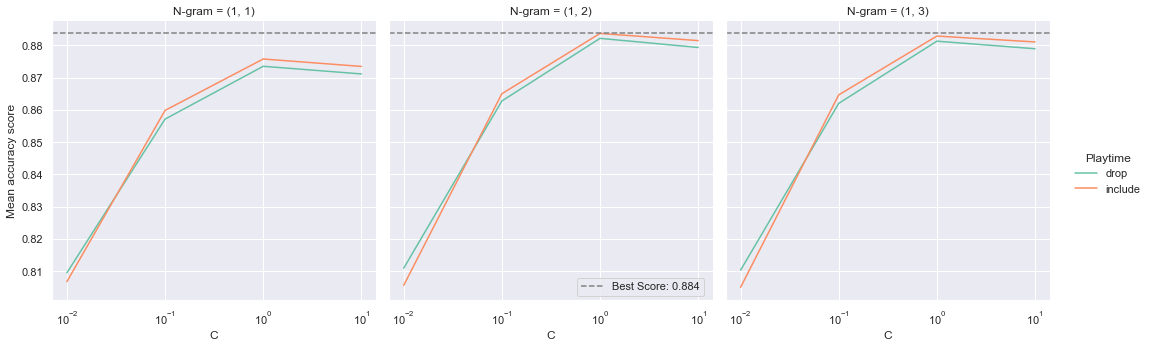

In [634]:
import seaborn as sns
sns.set()

# Create dataframe with the gridsearch results
log_results = pd.DataFrame(search_log.cv_results_)

# Rename gridsearch rseults parameter columns for easier selection. i.e.'param_classifier__C' -> 'C' 
old_cols_log = {'param_' + i: v for i,v in grid_params_log.items()}
new_cols_log = dict(zip(old_cols_log ,['C','N-gram','Playtime']))
log_results.rename(new_cols_log, axis=1, inplace=True)

# For the Playtime inclusion column, when playtime is included, the value is the whole column pipeline. This makes it more concise.
log_results.loc[log_results['Playtime'] != 'drop','Playtime'] = 'include'

# Plot the results including a reference for the highest achieved score
plot = sns.relplot(data=log_results, x='C', y = 'mean_test_score', col='N-gram',hue='Playtime',kind='line',palette=('Set2'))
plot.set(xscale = 'log', ylabel = 'Mean accuracy score')
plot.refline(y=search_log.best_score_, label='Best Score: %0.3f' %search_log.best_score_)
plt.legend(bbox_to_anchor=(-0.05,0.1))

##### C Value and Regularization
The gridsearch results show us that the most significant parameter that affects accuracy is C. Lower C values penalize high weights to regularize the model and avoid overfitting. Strong regularization could be more useful when the number of training samples is smaller, since having a strong training/validation performance on a small number of samples won't strictly translate to similarly high testing and practical performance. But since we're training the model with 128,000 samples, or 96,000 samples since we're cross validating, we can assume assume that our extensive training data would translate well to real-life applications. Thus, extra regularization by setting very low C values actually causes the model to underfit comapred to higher values. 

Interestingly, when C gets higher than 1, performance dips slightly implying that the model is starting to overfit to the training data. This could imply that there are still undeniable nuanced differences with how individuals, or in this case large groups of people, express themselves and their sentiment.

##### N-grams A.K.A The Number of Consecutive Words to be Treated as a Single Feature
The difference between only looking at single words versus combinations of words is really important when it comes to machine learning. We're normally able to intuite the differences between
- 'I like chocolate' 
- 'I don't like chocolate' 
- 'I don't dislike choclate'
Adding words like "don't" can change the meaning of the whole sentence, so if we train a model to only look at single words, it'd have a really tough time with these statements because its 'vision' can only see 'like' as a single word and "don't" as a single word, and it neither knows the order or the implications of either. When instead we use not just single words, but combinations, as features, our model can then map 'don't like' as a negative sentiment, and 'don't dislike' as a positive one.

So it's no surprise that our model performs better when setting it to consider bigrams and trigrams as features. What's interesting, is how well it performs with just unigrams. This could imply that game reviews are generally more concisely written. The minor difference between the best trigram and bigram scores could be attributed either to some sort of linguistic overfitting caused by common 3 word phrases or names, or just subtleties in this specific training set, given how close they are.

##### Including Playtime
Intuitively, if someone likes a game, they tend to play it for longer before leaving a review. Conversly, if someone dislikes a game, or faces many bugs and issues, they're likely to stop playing it and leaving a negative review. This was the initial basis of using the playtime at review as a predictor.

In (8), we observed certain nuanced differences between the playtime probability distributions for positive and negative reviews. But in general, they mostly overlapped. In (8) and (9) We built models that showed that it had *some* predictive value but only as a complementary feature to the review text. We can see the same in this gridsearch. Including playtime very slightly raised accuracy performance compared to dropping it. But this minor improvement isn't too convincing when we consider requiring a completely separate input that limits our flexibility. We'll have a better idea of the most value we can pull from it given this investigation's scope after testing a more complex neural network model.

#### Best Logistic Regression Model Test Performance

In [648]:
# Testing the optmizied logistid regression model on the test set
y_pred = search_log.predict(X_test)
accuracy_score(y_test,y_pred)

0.88690625

88.7% accuracy over 32,000 test reviews means that our model is really effective. This model is a strong candidate going forward. Next, we'll create and optimize a neural network based model and compare its best results with and without playtime with these ones.

### Neural Network Model
#### Pipeline & Gridsearch

Like before, we'll build a pipeline for our model, this time with a neural network based classifier. The preprocessing and data transformations are the same so we can use the column transofmer we already built. 

##### N-gram Assumptions
In the logistic regression gridsearch we got the highest accuracy surprisingly with our vectorizer checked only unigrams and bigrams. The inclusion of trigrams yeilding slightly lower validation accuracy. Even though a neural network based model might be able to better utilize trigrams, for the sake of having a semi-reasonable computation time, we'll only use unigrams and bigrams. This was set already in the original vectorizer object above.

In [625]:
from sklearn.neural_network import MLPClassifier

# Define our neural network classifier and make our model with the column transformations from before.
mlp_clf = MLPClassifier()
nn_pipe = Pipeline([('transformer', ct),('nn_classifier',mlp_clf)])

# Define the parameters we'll be changing and the values we'll test.
grid_params_nn = {'nn_classifier__hidden_layer_sizes':[(50),(50,50),(50,50,50)],    # Different hidden layer arrangements to try different complexities
                  'nn_classifier__max_iter': [1,2,3],   # The number of iterations affects under/over fitting, so we'll test different ones. They're all low because the taraining set is 124k samples
                  'nn_classifier__alpha':[0.01,0.001,0.0001],    # Testing different alphas to also optimize the level of regularization
                  'transformer__prep':['drop',playtime_pipe]    # Like the logistic regression model; classify with and without Playtime data
                  }

# Like before, we'll do 4-fold cross validation and maximize accuracy
search_nn= GridSearchCV(nn_pipe, grid_params_nn, scoring = 'accuracy', n_jobs=-1, cv=4)

search_nn.fit(X_train,y_train)
search_nn.best_params_

{'nn_classifier__alpha': 0.0001,
 'nn_classifier__hidden_layer_sizes': (50, 50, 50),
 'nn_classifier__max_iter': 1,
 'transformer__prep': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value=1e-06, strategy='constant')),
                 ('log transform', FunctionTransformer(func=<ufunc 'log'>))])}

Looking at the best parameters, the ones that initially stand out are the neuron arrangement with 3 hidden layers, as well as the inclusion of playtime. We'll still need to investigate the results of the different parameter values to get a better understanding of what happened.
#### Neural Network Model Analysis
Like we did with the logistic regression model, we'll graph the scores for the different parameter combinations and analyze their effects.

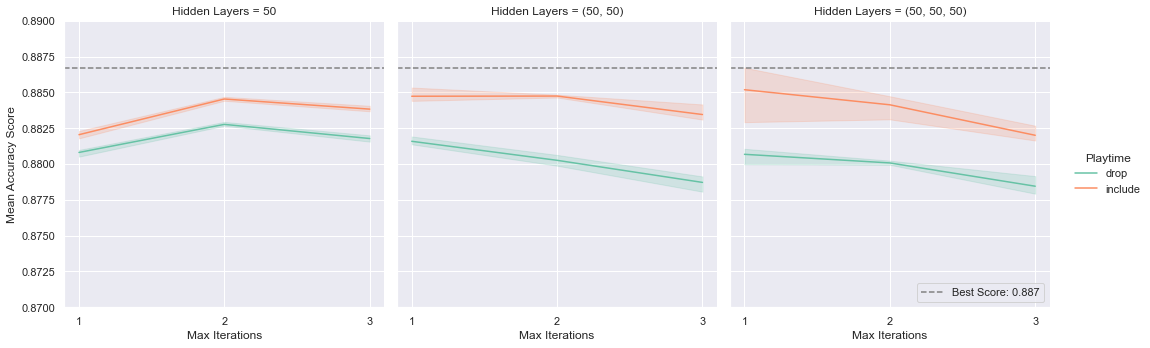

In [645]:
# Create dataframe with the gridsearch results
nn_results = pd.DataFrame(search_nn.cv_results_)

# Rename gridsearch rseults parameter columns for easier selection
old_cols_nn = {'param_' + i: v for i,v in grid_params_nn.items()}
new_cols_nn = dict(zip(old_cols_nn,['Hidden Layers','Max Iterations','Alpha', 'Playtime']))
nn_results.rename(new_cols_nn, axis=1, inplace=True)

# Shorten Playtime inclusion identifier
nn_results.loc[nn_results['Playtime'] != 'drop','Playtime'] = 'include'

# Plot the results including a reference for the highest achieved score
plot = sns.relplot(data=nn_results,x='Max Iterations', y='mean_test_score',col='Hidden Layers',kind='line' , hue='Playtime', palette='Set2')
plot.set(xticks=[1,2,3], ylim=(0.87,0.89), ylabel='Mean Accuracy Score')
plot.refline(y=search_nn.best_score_, label='Best Score: %0.3f' %search_nn.best_score_)
plt.legend(loc=4)


##### Number of Iterations
The results show that more iterations lead to lower performance as we increase the number of hidden layers. This implies that as the model becomes more complex, it's more readily able to fit the training data in the same number of update steps. We can especially see this in simplest model with 1 hidden layer since it's the only model that has a noticable increase in performance with an extra iteration. Overall, the we saw the best performance with our 3 layer model which starts overfitting after an extra iteration, so going forward we'll use only 1. 

Note that this is also a function of the size of the training set and the batch size. We're training this model with 96,000 samples per CV and a minibatch size of 200, meaning that the model and weights were updated 480 times per iteration. If there were less updates per iteration either because of a smaller training set or bigger batches, then we'd need to try more iterations to find the point where performance starts dropping.

##### Model Complexity
As we add more hidden layers our model is better able to fit the training data. Like we discussed above, the simplest model needs two epochs to reach peak performance while the other other models already start overfitting at the second epoch. Interestingly, the most complex model achieves a higher peak accuracy than the two hidden layer model even though they both start losing accuary at the second epoch. This observation only happens when the playtime data is included, which could imply that the more compelx model is able to better extract the nuances of playtime's effect, and its interactions with the review text. 

##### Including Playtime 
The interaction between the review text and playtime is an interesting and subtle possible predictor. This is because reviews can sometimes have neutral or ambiguous words that only imply the reviewer's sentiment when considering how long they played the game before they left the review.

An example would be if a review uses phrases like 'couldnt stop' or 'quickly tried'. On their own, these tokens could apply to many different contexts both positive and negative about details in the game and not necissarily how long the reviewer played the game. But when our model is trained with the playtime data and is also enough to identify these patterns, then it would be better able to classify these types of reviews.

##### Alpha / Regularization

Alpha is the Scikit's regularization parameter in its MLP classifier. It prevents over fitting by constraining the model's weights. For the sake of clarity in the graphs above, the range of different alpha values were shown as areas. To better analyze its effect, lets only graph our best performing model.

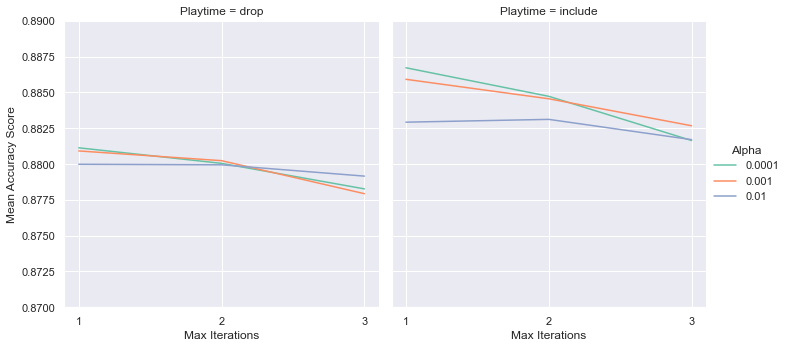

In [646]:
# Filter and graphing only the results from the most compelx model
three_layer_results = nn_results.loc[nn_results['Hidden Layers'] == (50,50,50)]
plot= sns.relplot(data=three_layer_results, x='Max Iterations', y='mean_test_score',kind='line',col='Playtime', hue='Alpha',palette='Set2')
plot.set(xticks=[1,2,3], ylim=(0.87,0.89), ylabel='Mean Accuracy Score')

First and foremost, we can see that Alpha is doing its job. At higher alpha values, the model's performance over multiple itereations doesn't drop as much as with lower values, hence it's stopping the model from over fitting. But conversly, we can see that at 1 epoch, heavily constraining the model's weights causes it to underfit. This shows that optimizing alpha strongly relies on the model's complexity, the number of steps per epoch, the number of epochs, and the size of the training data. In our specific case, our model is actually still simple enough to not overfit our data at 1 epoch, so a low alpha leads to the best performance.

#### Best Nerual Network Model Test Perfomance

In [627]:
# Testing the optmizied logistid regression model on the test set
y_pred_nn = search_nn.predict(X_test)
print(accuracy_score(y_test,y_pred_nn))

0.88828125


Similar to the best logistic regresion model, 88.8% over 32k test samples is perfectly acceptable given the relative simplicity of our neural network model compared to more suitable deep CNN's and RNN's.

### Logistic Regression vs. Neural Network and Playtime's Value
Now with our gridsearches complete and our best models identified, let's compare our two classifiers and their best results both with and without playtime. 

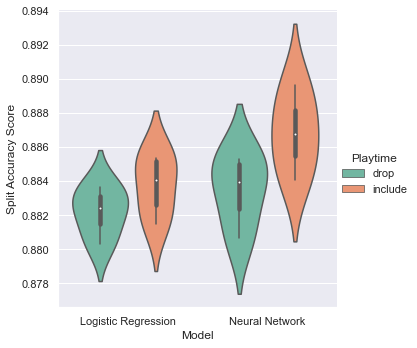

In [778]:
# Get only the highest scores in each model with and without playtime
log_top = log_results.groupby(['Playtime'], as_index=False).max()
nn_top = nn_results.groupby(['Playtime'], as_index=False).max()

# Add a column signifying the model
log_top['Model'] = 'Logistic Regression'
nn_top['Model'] = 'Neural Network'

# Combine both dataframes
top = pd.concat([log_top,nn_top])

# Unpivot the CV split scores
top = top.melt(id_vars=['Model','Playtime'], value_vars=['split%d_test_score' %i for i in range(4)], value_name='split score')

plot = sns.catplot(data=top,hue='Playtime', x='Model', y='split score',kind='violin',inner='box', palette='Set2', ax=ax[0])
plot.set(ylabel='Split Accuracy Score')


For both models, including playtime gives better scores on average, but the benefit is minor. Even with such small improvements, our complex neural network model is able to extract slightly more performance (0.3% mean increase) versus the logsitc regression (0.1%).

Another finding is the degree of overlap between the models. The logistic regression classifier with no playtime values might have the lowest mean score, but most of its split scores are well within the accuracy ranges of the other models. This shows that all the models have a similar capability in terms of predicting sentiment with the data available to them with only the highest performer pulling slightly ahead.

### Discussion and Use Cases
By knowing the performance of our different models and the inputs they need, we can make educated decisions on which one to implement for a given task. The benefit of using a logistic regression is that it's relatively transparent to understand and dissect. With normalized features, the weights allow us to directly observe the magnitude and sentiment of each feature and build a better sense of what featues have the most effect on our predictions. It's also very fast to fit to the data, and as we saw in the model comparison, it performs at a similar accuaracy level to more complex models. It would be most effective to use a logistic regression based model in an analytical or investigative project that aims to not only fit the model to large sets of data, but also to identify the most influential features and understand their effects on the final classification.

The neural network classifer on the other hand produced marginally better accuracy and the ability to extract nuanced effects and relations from ambiguos features like we observed with the playtime values. In that sense, it would be more suited to applications that are naturally complex to the point where other models fail to achieve acceptable results, and for applications where accuracy directly translates to manhours and costs. For example if a system flags reviews where the writer put a reccomendation sentiment that doesn't match what they wrote, then it should be as accurate as possible to properly identify these cases and to reduce the time needed for a person to confirm these flags. In more general applications such as spam detection or other classification problems that are sensitive or would be costly to review, achieving the highest accuracy and percision would be essential.

Regarding the inclusion of playtime as a predictor, we observed that it did improve our accuracy, but that improvement was really minor. In that sense, it would be most appropriate to include only in applications where playtime is consistently measured and reported. For online gaming marketplaces such as Steam, this is not an issue as seen by this data set, so it would be beneficial to include it in the analysis. However, for models that would scrape online forums or review websites that don't reliably track playtime, then it would be more effective to simply build a model that doesn't need playtime as a predictor. We already observed that models based only on the review text perform well within the accuracy range of ones with playtime, so it's truly dependent on the application and available inputs.

#### Next Steps
This investigation was both fruitful and revealing in both both the efficacy of different models and predictors, and we were able to build working classifiers that can reliably predict the sentiment of a game review with up to 88.8% accuracy. The natural next step would be to use deep learning models such as CNNs and RNNs to push our performance even higher and achieve a production level model that Steam or any group looking to classify text can utilize.

Another factor to consider in future investigations is the use of other classification measures such as precision and recall. For topics were classifications are more critical such as disease detection, national and cyber security, or even spam detection being able to maximize true positives and minimize false negatives is essential.
